# Parameters Tuning for classification accuracy - Canine Sarcomas data
Dataset can be downloaded from https://www.ebi.ac.uk/pride/archive/projects/PXD010990 and paper from https://doi.org/10.1016/j.ccell.2018.09.009.

## Preparation

In [1]:
import os,csv,random
import pandas as pd
import numpy as np
import scanpy as sc
import math

from skimage import io, color
import torch

In [2]:
from scanpy import read_10x_h5
import SpaGCN as spg
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import pickle

In [3]:
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.metadata import Metadata

In [4]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
import anndata as ad

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

In [ ]:
import scipy.stats as stats

In [6]:
%cd /Users/anjideng1/Desktop/MALDI

/Users/anjideng1/Desktop/MALDI


In [7]:
import sys
sys.path.append('/Users/anjideng1/Desktop/MALDI/MALDI_package')

import MALDI_package as MALDIpy
MALDIpy.__version__

'1.0.0'

## Reading Data
import Ds1, (2), 3, 4, 18, 19, 20, 24, (26) (normal)

In [8]:
file_loc = '/Users/anjideng1/Desktop/MALDI/data/CanineSarcomas'

In [96]:
par_peak = 0.95
par_cluster = 0.9

In [97]:
data_list = ['1', '2', '3', '4', '18', '19', '20', '24']

## Before alignment

In [69]:
rate_misaligned = []
data_list

['1', '2', '3', '4', '18', '19', '20', '24']

In [70]:
for data_id in data_list:

    # reading data
    MALDIdataAnn_cancer = sc.read_h5ad(filename  = file_loc + "/CanineSarcomas_Ds" + data_id + ".h5ad")
    MALDIdataAnn_normal = sc.read_h5ad(filename  = file_loc + "/CanineSarcomas_Ds26.h5ad")
    
    ## gridding parameter = 0.5
    # MALDIdataAnn_cancer = sc.read_h5ad(filename  = file_loc + "/CanineSarcomas_Ds" + data_id + "_05.h5ad")
    # MALDIdataAnn_normal = sc.read_h5ad(filename  = file_loc + "/CanineSarcomas_Ds26_05.h5ad")

    MALDIdataAnn_cancer.obs = MALDIdataAnn_cancer.obs.astype(int)
    sc.pp.normalize_per_cell(MALDIdataAnn_cancer)

    MALDIdataAnn_normal.obs = MALDIdataAnn_normal.obs.astype(int)
    sc.pp.normalize_per_cell(MALDIdataAnn_normal)
    
    # log transformation
    # MALDIdataAnn_cancer.X = np.log1p(MALDIdataAnn_cancer.X)
    # MALDIdataAnn_normal.X = np.log1p(MALDIdataAnn_normal.X)
    
    # PCA
    data = ad.concat([MALDIdataAnn_cancer, MALDIdataAnn_normal])
    df = ad.AnnData.to_df(data)

    pca = PCA(n_components = 3)
    pca.fit(df)
    df_pca = pca.transform(df)

    data_pca = pd.DataFrame(data = df_pca, columns = ['pc1', 'pc2', 'pc3'])

    cell_type = ['cancer'] * len(MALDIdataAnn_cancer) + ['normal'] * len(MALDIdataAnn_normal)
    data_pca['cell_type'] = cell_type


    # LDA
    lda = LinearDiscriminantAnalysis()
    loo = LeaveOneOut()

    X = data_pca[['pc1', 'pc2', 'pc3']].to_numpy()
    y = data_pca['cell_type'].to_numpy()

    correct_count = 0

    for train_index, test_index in tqdm(loo.split(data_pca[['pc1', 'pc2', 'pc3']])):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lda.fit(X_train, y_train)
        y_pred = lda.predict(X_test)

        if y_pred == y_test:
            correct_count += 1

    correct_rate = correct_count / len(data_pca)

    rate_misaligned.append(correct_rate)

/Users/anjideng1/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
17326it [11:00, 26.22it/s]
/Users/anjideng1/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
33378it [45:29, 12.23it/s]
/Users/anjideng1/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
24154it [21:37, 18.62it/s]
/Users/anjideng1/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
18460it [12:33, 24.49it/s]


In [71]:
rate_misaligned

[0.8533417984531917,
 0.9977530109653064,
 0.9387265049267202,
 0.9885157096424702,
 0.8838425033367937,
 0.9951961569255404,
 0.9748098859315589,
 0.959643316786174]

## After alignment

In [9]:
data_list = ['1', '2', '3', '4', '18', '19', '20', '24']

In [11]:
par_peak = 0.95
par_cluster = 0.9
rate_aligned = []

In [12]:
for data_id in data_list: 

    # reading data
    MALDIdataAnn_cancer = sc.read_h5ad(filename  = file_loc + "/CanineSarcomas_Ds" + data_id + "_05.h5ad")
    MALDIdataAnn_normal = sc.read_h5ad(filename  = file_loc + "/CanineSarcomas_Ds26_05.h5ad")

    MALDIdataAnn_cancer.obs = MALDIdataAnn_cancer.obs.astype(int)
    sc.pp.normalize_per_cell(MALDIdataAnn_cancer)

    MALDIdataAnn_normal.obs = MALDIdataAnn_normal.obs.astype(int)
    sc.pp.normalize_per_cell(MALDIdataAnn_normal)


    # peak calling and group alignment
    PeakGroup = MALDIpy.PeakCalling(MALDIdataAnn_cancer, MALDIdataAnn_normal)
    PeakGroup.callpeak(par_peak)
    PeakGroup.grouppeaks(par_cluster)

    ExactAlign = MALDIpy.AnnDataMALDI(MALDIdataAnn_cancer, MALDIdataAnn_normal)
    ExactAlign.get_corr_peakgroup_refined(PeakGroup.jointcluster)
    ExactAlign.greedy_match()
    ExactAlign.fine_align(threshould = 0.2, ignore = True)

    Aligned = MALDIpy.PGmzalign(ExactAlign)
    MALDIdataAnn_cancer_aligned = Aligned.getAnnSim()
    
    MALDIdataAnn_cancer_aligned.obs = MALDIdataAnn_cancer_aligned.obs.astype(int)
    sc.pp.normalize_per_cell(MALDIdataAnn_cancer_aligned)


    # PCA
    data = ad.concat([MALDIdataAnn_cancer_aligned, MALDIdataAnn_normal])
    df = ad.AnnData.to_df(data)

    pca = PCA(n_components = 3)
    pca.fit(df)
    df_pca = pca.transform(df)

    data_pca = pd.DataFrame(data = df_pca, columns = ['pc1', 'pc2', 'pc3'])

    cell_type = ['cancer'] * len(MALDIdataAnn_cancer_aligned) + ['normal'] * len(MALDIdataAnn_normal)
    data_pca['cell_type'] = cell_type


    # LDA
    lda = LinearDiscriminantAnalysis()
    loo = LeaveOneOut()

    X = data_pca[['pc1', 'pc2', 'pc3']].to_numpy()
    y = data_pca['cell_type'].to_numpy()
    correct_count = 0

    for train_index, test_index in tqdm(loo.split(data_pca[['pc1', 'pc2', 'pc3']])):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lda.fit(X_train, y_train)
        y_pred = lda.predict(X_test)

        if y_pred == y_test:
            correct_count += 1

    correct_rate = correct_count / len(data_pca)

    rate_aligned.append(correct_rate)

100%|██████████| 28/28 [00:09<00:00,  2.94it/s]
/Users/anjideng1/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/anjideng1/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
17326it [11:16, 25.62it/s]
100%|██████████| 27/27 [00:09<00:00,  2.86it/s]
/Users/anjideng1/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/anjideng1/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs

In [ ]:
rate_aligned

[0.8615952903151334,
 0.9905027263466955,
 0.933799784714747,
 0.9770855904658722,
 0.9017499629245143,
 0.9459567654123299,
 0.9756020278833967,
 0.9609762824048539]

## Test for classification accuracy - 0.5, 0.9, 0.9

In [17]:
rate_misaligned = [0.8581900034630036,
 0.9952663431002456,
 0.9511468079821148,
 0.9896533044420368,
 0.8914429779030105,
 0.9900364736233431,
 0.9758132657372202,
 0.9538058466629895]

In [18]:
rate_aligned = [0.8550733002424102,
 0.9934088321648991,
 0.9468825039330959,
 0.9852654387865656,
 0.8852142963072817,
 0.992660795302909,
 0.9954583861427968,
 0.9509100937672367]

### Wilcoxon signed-rank

In [20]:
stats.wilcoxon(rate_misaligned, rate_aligned, alternative = 'greater') # wish to not reject

WilcoxonResult(statistic=26.0, pvalue=0.15625)

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
data_accuracy = {'before alignment': rate_misaligned,
                 'after alignment': rate_aligned}
df = pd.DataFrame(data_accuracy)

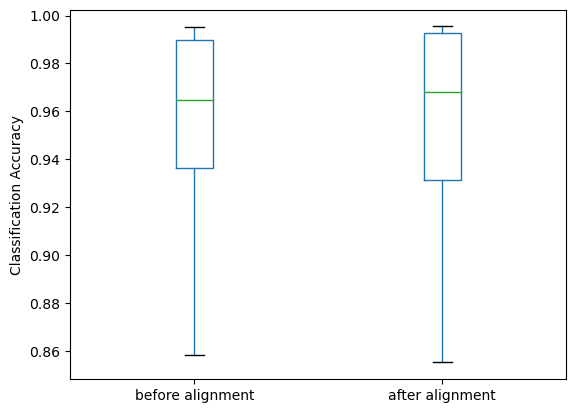

In [27]:
df.boxplot(grid = False)
plt.ylabel("Classification Accuracy")
plt.show()

## Test for classification accuracy - 0.25, 0.9, 0.95

In [85]:
rate_misaligned = [0.8533417984531917,
 0.9977530109653064,
 0.9387265049267202,
 0.9885157096424702,
 0.8838425033367937,
 0.9951961569255404,
 0.9748098859315589,
 0.959643316786174]

In [86]:
rate_aligned = [0.8505713955904421,
 0.9978428905266943,
 0.9367806574480417,
 0.9882990249187432,
 0.8788373127687973,
 0.9967084778934259,
 0.9743346007604563,
 0.9590917448060305]

In [87]:
stats.wilcoxon(rate_misaligned, rate_aligned, alternative = 'greater')

WilcoxonResult(statistic=30.0, pvalue=0.0546875)

## Test for classification accuracy - 0.25, 0.9, 0.9

In [51]:
rate_misaligned = [0.8533417984531917,
 0.9977530109653064,
 0.9387265049267202,
 0.9885157096424702,
 0.8838425033367937,
 0.9951961569255404,
 0.9748098859315589,
 0.959643316786174]

In [52]:
rate_aligned = [0.8494747777906038,
 0.9979028102342861,
 0.9351246170406557,
 0.9877031419284941,
 0.878911463740175,
 0.9966639978649586,
 0.9853189691592733,
 0.9595973524544953]

In [53]:
stats.wilcoxon(rate_misaligned, rate_aligned, alternative = 'greater')

WilcoxonResult(statistic=22.0, pvalue=0.3203125)

## Test for classification accuracy - 0.5, 0.9, 0.95

In [11]:
rate_misaligned = [0.8581900034630036,
 0.9952663431002456,
 0.9511468079821148,
 0.9896533044420368,
 0.8914429779030105,
 0.9900364736233431,
 0.9758132657372202,
 0.9538058466629895]

In [12]:
rate_aligned = [0.8576128361999308,
 0.9967343759362455,
 0.9504015897987911,
 0.9878114842903575,
 0.8904419397894112,
 0.9895471933102037,
 0.9752851711026616,
 0.9532542746828461]

In [13]:
stats.wilcoxon(rate_misaligned, rate_aligned, alternative = 'greater')

WilcoxonResult(statistic=29.0, pvalue=0.07421875)